# Normaler Zeemann Effekt

In [105]:
import os

import matplotlib.pyplot as plt
from scipy import odr, optimize
from typing import Callable, Tuple
import numpy as np
import pandas as pd
from monke import functions, plots, constants
import scienceplots.styles

plt.style.use("science")
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.dpi"] = 150



## Kalibrationskurve
Fitte an die Messung des Magnetfeldes in Abhängigkeit des Spulenstroms eine Funktion, um aus den Strömen
das Magnetfeld bestimmen zu können. Dies wird für die Magnetfeldmessung vor und nach dem Versuch durchgeführt. Ein Fit 
wird mit der Anpassung 
$$B(I) = \alpha + \frac{\beta}{(\gamma + e^{-\delta I})^{\epsilon}}$$
durchgeführt.

Der Fehler für das Magnetfeld wird so bestimmt, das in den Daten ein Bereich ausgewählt wird, wo viele sequentielle Messungen bei konstantem 
Strom durchgeführt wurden. von den Magnetfelddaten wird die Standardabweichung gebildet und als konstanter Fehler genutzt.
Dem Strom wird kein Fehler zugeordnet. Der Fit wird mit `scipy.optimize` durchgeführt. Da alle Messwerte einen 
gleichen Fehler besitzen, ist dieser für den Fit irrelevant. Wie man die Güte des Fits berechnet ist noch unklar.

/home/gabriel/anaconda3/envs/p4_312/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


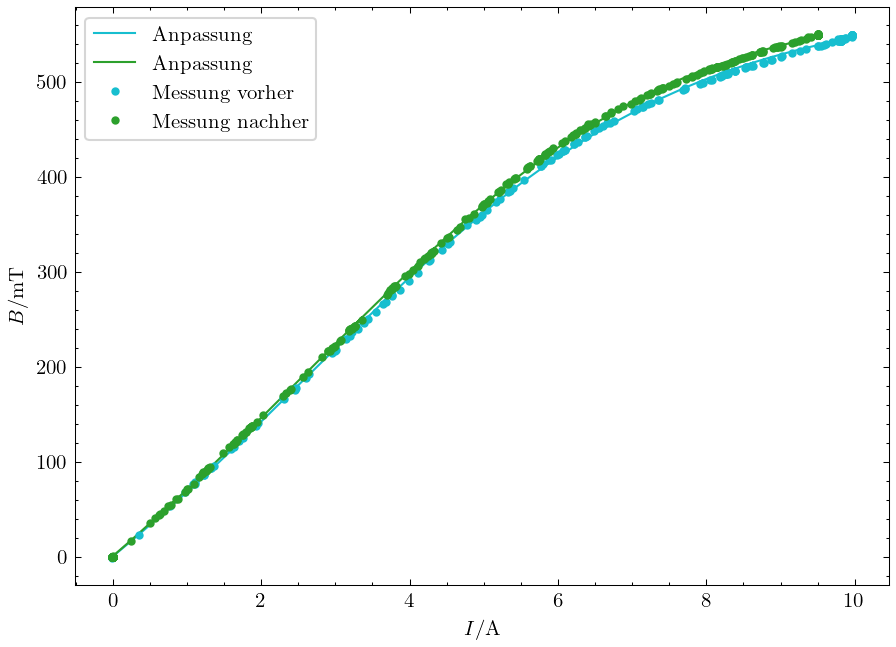

In [119]:
func = Callable[[float], float]

def fit_function(x: float, a: float, b: float, c: float, d: float, e: float) -> float:
    """Fit Funktion für das Magnetfeld nach der oben beschriebenen Formel"""
    denom = (c + np.exp(-d*x))**e

    return a + b / denom
    

def do_calibration(data: pd.DataFrame, sy) -> Tuple[any, any, func]:
    """Führe mit scipy.optimize eine Funktionsanpassung an den Datensatz durch"""
    x = data["I / A"]
    y = data["B / mT"]
    
    popt, pcov = optimize.curve_fit(fit_function, x, y)
    
    return popt, pcov, lambda x: fit_function(x, *popt)

# Lese die Daten ein
data_before: pd.DataFrame = pd.DataFrame(np.loadtxt("../Data/Zeeman2/kalibrierung_nachher.txt", skiprows=1), columns=["I / A", "B / mT"])
data_after: pd.DataFrame = pd.DataFrame(np.loadtxt("../Data/Zeeman3/kalibrierung_nachher.txt", skiprows=1), columns=["I / A", "B / mT"])
#data_after.plot(kind="scatter", x="I / A", y="B / mT")

data_std: float = round(np.std(data_before[200:]["B / mT"]), 1)

# Führe Kalibration durch
beta_before, sd_beta_before, bfield_before = do_calibration(data_before, data_std)
beta_after, sd_beta_after, bfield_after = do_calibration(data_after, data_std)

# Plotte die Fits
fig, ax = plt.subplots()
ax.set_xlabel(r"$I / \mathrm{A}$")
ax.set_ylabel(r"$B / \mathrm{mT}$")

ax.errorbar(data_before["I / A"], data_before["B / mT"], yerr=data_std, 
            linestyle="", ms=3, marker="o", label="Messung vorher", color="tab:cyan")
ax.plot(data_before["I / A"], bfield_before(data_before["I / A"]), label="Anpassung", color="tab:cyan")

ax.errorbar(data_after["I / A"], data_after["B / mT"], yerr=data_std, 
            linestyle="", ms=3, marker="o", label="Messung nachher", color="tab:green")
ax.plot(data_after["I / A"], bfield_after(data_after["I / A"]), label="Anpassung", color="tab:green")

plots.legend(ax)
fig.savefig("../figs/BFeld-Kalibrationskurve.pdf", dpi=200)
#plt.show()

 


## Gauss Fits an erstes äußeres Maximum
Aufgrund der Zeeman-Aufspaltung sind die Maxima der Interferenzkurven in drei symmetrische (hoffentlich) Gauss-Kurven 
aufgespalten. Mit `scipy.odr` wird damit für alle gemessenen Ströme die Winkelaufspaltung bestimmt.


